In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import elasticsearch
from elasticsearch import helpers

# PROCESS A SINGLE PATHWAY FILE

In [2]:
input_file = "gene_set_data/gene_set_R-HSA-109582"

In [3]:
df = pd.read_csv(input_file, sep="\n", header=None)
df

,0
0,Formation of Fibrin Clot (Clotting Cascade)\tR...
1,Cell surface interactions at the vascular wall...
2,Platelet homeostasis\tR-HSA-418346\tAPOB\tATP2...
3,Dissolution of Fibrin Clot\tR-HSA-75205\tANXA2...
4,Platelet Adhesion to exposed collagen\tR-HSA-7...
5,"Platelet activation, signaling and aggregation..."
6,Factors involved in megakaryocyte development ...


In [4]:
df = df[0].str.split("\t", expand=True).transpose()
df.columns = df.iloc[0]
df.drop([0,1], inplace=True)

In [5]:
df.reset_index(drop=True, inplace=True)
df.head()

,Formation of Fibrin Clot (Clotting Cascade),Cell surface interactions at the vascular wall,Platelet homeostasis,Dissolution of Fibrin Clot,Platelet Adhesion to exposed collagen,"Platelet activation, signaling and aggregation",Factors involved in megakaryocyte development and platelet production
0,A2M,ANGPT1,APOB,ANXA2,FCER1G,A1BG,ABL1
1,C1QBP,ANGPT2,ATP2A1,HRG,FYN,A2M,AK3
2,CD177,ANGPT4,ATP2A2,PLAT,GP1BA,AAMP,AKAP1
3,F10,APOB,ATP2A3,PLAU,GP1BB,ABCC4,AKAP10
4,F11,ATP1B1,ATP2B1,PLAUR,GP5,ABHD12,CABLES1


In [6]:
gene_set = set()

for colname in df:
    gene_set.update(list(df[colname][~df[colname].isnull()]))

In [7]:
df.count()

0
Formation of Fibrin Clot (Clotting Cascade)                               39
Cell surface interactions at the vascular wall                           231
Platelet homeostasis                                                      87
Dissolution of Fibrin Clot                                                13
Platelet Adhesion to exposed collagen                                     13
Platelet activation, signaling and aggregation                           260
Factors involved in megakaryocyte development and platelet production    139
dtype: int64

In [8]:
print("Not null values in df: {}".format(df.count().sum()))

Not null values in df: 782


In [9]:
# Function that looks up each gene in ES
def sentence_search(gene_symbol, index_name="dgnplus_gene_v19"):
    resp = helpers.scan(
        elasticsearch.Elasticsearch([{'host': '127.0.0.1', 'port': 3307}]),
        index=index_name,
        scroll='8m',
        size=1000,
        query={
            "_source": ["symbol_keyword", "geneID"], # fields we want to retrieve
            "query": {
                "term": {"symbol_keyword": {"value": gene_symbol}} # PMID to search for
            }
        }
    )
    if resp:
        return resp
    else:
        return None

In [10]:
# Test it works with a small subset of genes
inpt = list(gene_set)[:5]
for gene in inpt:
    print("RESULT:")
    for i in sentence_search(gene):
        print(i)
    print()

RESULT:
{'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': '_oTkJIEB-LRK_hoyoqkz', '_score': None, '_source': {'geneID': 2162, 'symbol_keyword': 'F13A1'}, 'sort': [5028]}

RESULT:
{'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': 'LITkJIEB-LRK_hoyoq80', '_score': None, '_source': {'geneID': 23046, 'symbol_keyword': 'KIF21B'}, 'sort': [32420]}

RESULT:
{'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': 'SITkJIEB-LRK_hoyoqkz', '_score': None, '_source': {'geneID': 10630, 'symbol_keyword': 'PDPN'}, 'sort': [62]}

RESULT:
{'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': 'gxngJIEB8V_vpxj_HZ1B', '_score': None, '_source': {'geneID': 22953, 'symbol_keyword': 'P2RX2'}, 'sort': [118140]}

RESULT:
{'_index': 'dgnplus_gene_v19', '_type': '_doc', '_id': 'lvjiJIEBfTBKnLAphzxh', '_score': None, '_source': {'geneID': 2782, 'symbol_keyword': 'GNB1'}, 'sort': [127396]}



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 7 columns):
 #   Column                                                                 Non-Null Count  Dtype 
---  ------                                                                 --------------  ----- 
 0   Formation of Fibrin Clot (Clotting Cascade)                            39 non-null     object
 1   Cell surface interactions at the vascular wall                         231 non-null    object
 2   Platelet homeostasis                                                   87 non-null     object
 3   Dissolution of Fibrin Clot                                             13 non-null     object
 4   Platelet Adhesion to exposed collagen                                  13 non-null     object
 5   Platelet activation, signaling and aggregation                         260 non-null    object
 6   Factors involved in megakaryocyte development and platelet production  139 non-null    object
dtype

# PROCESS ALL PATHWAY FILES

In [12]:
# Get all gene_set_pathway files 
dir_path = os.getcwd()
tmp = os.listdir(dir_path + "/gene_set_data")
input_files = [ dir_path + "/gene_set_data/" + file_name for file_name in tmp ]

In [13]:
# Create df that stores the relationship between pathway ID and pathway name
pathways_names_path = os.getcwd() + "/Reactome_TopLevel_Pathways.tsv"
pathways_names = pd.read_csv(pathways_names_path, sep="\t", header = 0)

In [14]:
# Reformat pathway IDs and store pairs in a dictionary
pathways_names.id = pathways_names.id.apply(lambda x: x.split(".")[0])
pathways_dict = dict(pathways_names.to_dict('split')['data'])

In [15]:
# Read each gene_set file and store genes in a df where each column represents a single top-level pathway
# with their corresponding genes
toplevel = pd.DataFrame()

for file in input_files:    
    pathway = pathways_dict[file.split("/")[-1].split("_")[-1]]
    df = pd.read_csv(file, sep="\n", header=None)
    df = df[0].str.split("\t", expand=True).transpose()
    df.columns = df.iloc[0]
    df.drop([0,1], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    gene_set = set()
    for colname in df:
        gene_set.update(list(df[colname][~df[colname].isnull()])) 
    
    tmp_df = pd.DataFrame()  
    tmp_df[pathway] = list(gene_set)
    toplevel = pd.concat([tmp_df, toplevel], axis=1)

In [16]:
toplevel.head()

,Protein localization,Circadian Clock,DNA Replication,Metabolism of proteins,Organelle biogenesis and maintenance,Extracellular matrix organization,Signal Transduction,Developmental Biology,Hemostasis,Chromatin organization,...,Cell Cycle,Disease,Reproduction,Gene expression (Transcription),DNA Repair,Sensory Perception,Immune System,Digestion and absorption,Metabolism,Programmed Cell Death
0,UBE2D1,ELOVL3,PSMA5,CSNK2A1,CETN2,MMP24,CSNK2A1,ARHGEF7,F13A1,SAP30,...,PPP2R2A,NCKAP1L,SYCP1,RRM2B,ASCC1,TMC1,TRAF7,LCT,RRM2B,PSMA5
1,UBE2J2,TBL1XR1,UBE2D1,LTBP1,PKD2,COL13A1,LTBP1,CSNK2A1,KIF21B,PAX3,...,CSNK2A1,RAE1,DMC1,CSNK2A1,BAZ1B,OR1J1,NCKAP1L,TREH,CSNK2A1,C1QBP
2,HSCB,CLOCK,H2BC15,KDELR1,POLG2,LTBP1,CCL21,DCX,PDPN,H2BC15,...,RAE1,FZD5,H2BC15,AEBP2,TIMELESS,LHFPL5,SIGLEC16,GUCA2A,STARD3,DIABLO
3,TIMM22,SMARCD3,H2AC7,RAE1,CEP164,JAM2,NCKAP1L,SCN5A,P2RX2,REST,...,NDC80,RPL36,REC8,RAE1,PRKDC,TAS1R3,RAE1,LIPF,RAE1,TRAF2
4,BAAT,TGS1,ORC3,RAB8B,ODF2,TPSAB1,FZD5,NR6A1,GNB1,AEBP2,...,RBBP7,MAT1A,SMC1A,PTPN4,ISY1,OR4F6,PTPN4,MGAM,RPL36,IL18


In [17]:
toplevel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Protein localization                  164 non-null    object
 1   Circadian Clock                       36 non-null     object
 2   DNA Replication                       157 non-null    object
 3   Metabolism of proteins                1947 non-null   object
 4   Organelle biogenesis and maintenance  282 non-null    object
 5   Extracellular matrix organization     295 non-null    object
 6   Signal Transduction                   2569 non-null   object
 7   Developmental Biology                 1107 non-null   object
 8   Hemostasis                            687 non-null    object
 9   Chromatin organization                240 non-null    object
 10  Metabolism of RNA                     724 non-null    object
 11  Muscle contraction            

In [18]:
total_non_null_values = toplevel.count().sum()
print(">>>> Non-null values in 'toplevel' dataframe: {}".format(total_non_null_values))

>>>> Non-null values in 'toplevel' dataframe: 21165


In [19]:
# Create a numpy array which stores the percentages of shared genes for each possible pathway-pathway pair
final_array = np.zeros(shape = (1, len(toplevel.columns)))

for idx, c_colname in enumerate(toplevel):
    tmp_array = np.zeros(shape=29)
    i_gene_set = set(toplevel[c_colname])
    length_i_genset = len(i_gene_set)
    
    for idx2, other_colname in enumerate(toplevel):
        o_gene_set = set(toplevel[other_colname])
        intersect = len(i_gene_set.intersection(o_gene_set)) # number of shared genes !!None is count as a value!!
        tmp_array[idx2] = intersect/length_i_genset * 100 # Calculate percentage of shared genes between sets
    final_array = np.vstack((final_array, tmp_array)) # Add new row of % to the final array
final_array = final_array[1:,:] # remove first row because it was just a full 0 row to initialize the array

In [20]:
# Reformat the labels so they fit in the following heatmap and create a df with the percentages info
labels = [sentence[:25] + "-\n" + sentence[25:] if len(sentence[25:])>4 else sentence[:25] 
          for sentence in list(toplevel.columns)]

final_df = pd.DataFrame(final_array, index = labels, columns = labels)

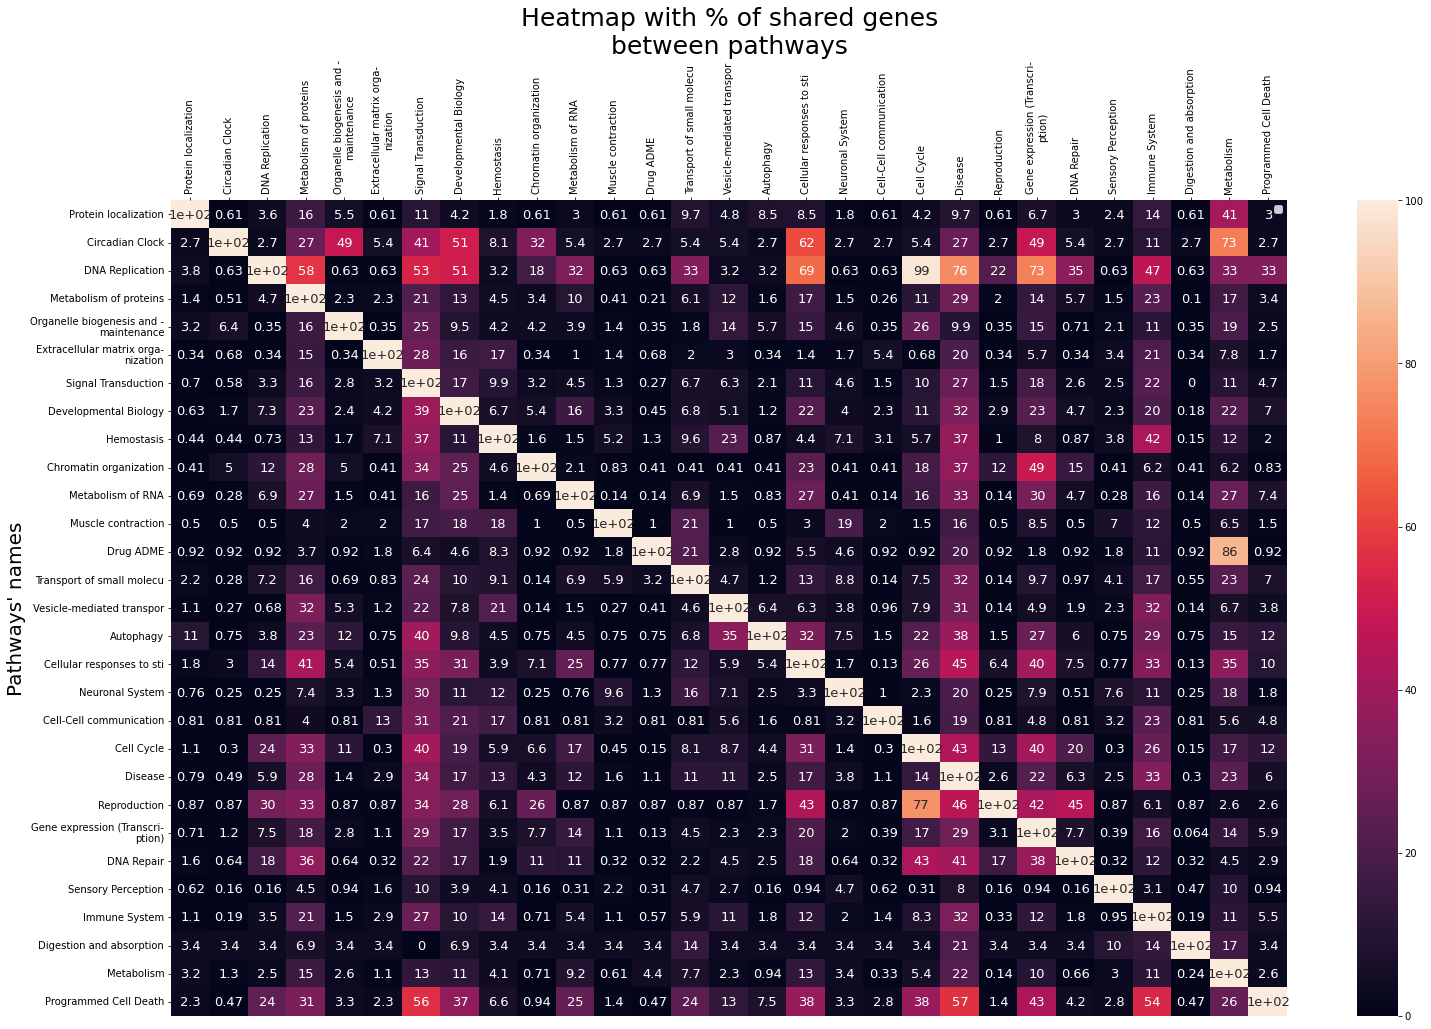

In [21]:
# Create heatmap object

# np.set_printoptions(formatter={'float_kind':'{:.2f}'.format})
np.set_printoptions(suppress=True)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(figsize = (25,15))
ax.set_title("Heatmap with % of shared genes\nbetween pathways", size = 25)
heatmap = sns.heatmap(final_df, annot = True, annot_kws={'size': 13})
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.set_ylabel("Pathways' names", size=20)
heatmap.legend("a")